# Práctica 2: Selección de características con sklearn
La selección de características peude usarse para reducir el volumen de un conjunto de datos y por tanto aumentar la velocidad con la que los datos pueden procesarse, o bien para mejorar la precisión de un algoritmo de aprendizaje, eliminando las variables que causen errores en el modelo.

## Modelos
- IRIS: Los datos están en el fichero siguiente: `datasets-uci-iris.csv`
- LETTER: Los datos están en el fichero siguiente: `datasets-uci-letter.csv`
- SINTETICO: El dataset se genera artificialmente:
```python
from sklearn.datasets import make_classification 
X, y = make_classification(n_samples=1000, 
                           n_features=10, 
                           n_informative=3, 
                           n_redundant=0, 
                           n_repeated=0, 
                           n_classes=2, 
                           random_state=0, 
                           shuffle=False) 
```

Los datasets que estén contenidos en ficheros .csv se cargarán en memoria en un dataframe pandas (nota: si el fichero csv incluye  cabecera, no son necesarios los argumentos "header" ni "names")

In [1]:
import datasets.datasets_synthetic
import pandas as pd
import utils

# Carga inicial de datasets
iris = pd.read_csv('datasets/datasets-uci-iris.csv', sep=',', decimal='.', header=None, names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target'])
letter = pd.read_csv('datasets/datasets-uci-letter.csv', sep=',', decimal='.')
synthetic = datasets.datasets_synthetic.gen()

iris_x, iris_y = utils.slice(iris)
letter_x, letter_y = utils.slice(letter)
synthetic_x = synthetic[0]
synthetic_y = synthetic[1]

print(f"Iris shape: {iris_x.shape}")
print(f"Letter shape: {letter_x.shape}")
print(f"Synthetic shape: {synthetic_x.shape}")


Iris shape: (150, 4)
Letter shape: (20000, 16)
Synthetic shape: (1000, 10)


## Parte 1. Eliminación de variables con poca varianza
Las variables cuyo valor sea constante o casi constante no aportan información al modelo y por tanto pueden ser eliminadas. Calcula la varianza de cada una de las variables para todos los datasets mencionados con la orden `np.var()` y anótala en el documento de prácticas.

Elimina de cada dataset las variables cuya varianza sea menor que el 10% de la varianza de la variable más dispersa, eligiendo el valor de XX en un script como el que sigue. Anota en el documento el código que hayas escrito para realizar esta tarea.

```python
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(XX)
# .iloc sirve para acceder al dataframe con indices numéricos
iris_reducido = sel.fit_transform(iris.iloc[:,0:4])
```

In [2]:
base = 0.1

iris_var = utils.reduce_by_var(iris_x, base)
letter_var = utils.reduce_by_var(letter_x, base)
# synthetic_var = utils.reduce_by_var(synthetic_x, base)

print(f"Iris reduced_by_var shape: {iris_var.shape}")
print(f"Letter reduced_by_var shape: {letter_var.shape}")
# print(f"Synthetic reduced_by_var shape: {syntehtic_var.shape}")


Iris reduced_by_var shape: (150, 3)
Letter reduced_by_var shape: (20000, 16)


## Parte 2. Eliminación de variables basada en estadísticos univariantes

Hay diferentes estadísticos que miden la calidad de una variable. Scikit-learn tiene implementados, entre otros, los siguientes métodos:
- `SelectKBest`: elimina todas las variables menos las k mejor valoradas.
- `SelectPercentile`: elimina todas las variables menos el porcentaje indicado.

Estos métodos hacen uso de una de las siguientes funciones para determinar si una variable
es relevante:
- Para regresión: `f_regression`
- Para clasificación: `chi2` o `f_classif`

El siguiente script realiza una selección de características sobre el problema Iris mediante el método `SelectKBest` con la función `chi2`. Aplica este método y `SelectPercentile` a todos los datasets de la práctica y anota las diferencias entre los mismos. Copia en el documento el código que hayas utilizado.
```python
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
sel = SelectKBest(chi2,k=2)
iris_reducido1 = sel.fit_transform(iris.iloc[:,0:4],iris.iloc[:,4])
```

In [3]:
k = 2

iris_uni = utils.reduce_with_univariate(iris_x, iris_y, k)
letter_uni = utils.reduce_with_univariate(letter_x, letter_y, k)
# synthetic_uni = utils.reduce_with_univariate(synthetic_x, synthetic_y, k)

print(f"Iris reduced_with_univariate shape: {iris_uni.shape}")
print(f"Letter reduced_with_univariate shape: {letter_uni.shape}")
# print(f"Synthetic reduced_with_univariate shape: {synthetic_uni.shape}")


Iris reduced_with_univariate shape: (150, 2)
Letter reduced_with_univariate shape: (20000, 2)


## Parte 3. Eliminación recursiva de variables
La eliminación recursiva de variables consiste en entrenar un modelo con todas las variables y determinar la importancia de cada una en el resultado. Se eliminan las variables con importancia menor y se repite el proceso. Mediante validación cruzada, se valora cada uno de los modelos que se vayan obteniendo y se determina el punto óptimo como aquél en el que el error del modelo sea menor.

Es necesario que el clasificador/modelo de regresión utilizado proporcione una medida de la importancia de cada variable para poder emplear este método.

```python
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
estimator = SVC(kernel="linear")
sel = RFECV(estimator, step=1, cv=5)
iris_reducido2 = sel.fit(iris.iloc[:,0:4],iris.iloc[:,4])
print sel.ranking_
print sel.support_
```

In [6]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC

estimator = SVC(kernel="linear")
selector = RFECV(estimator, step=1, cv=5)

iris_rfe = utils.reduce_with_rfe(iris_x, iris_y)
# letter_rfe = utils.reduce_with_rfe(letter_x, letter_y)
synthetic_rfe = utils.reduce_with_rfe(synthetic_x, synthetic_y)

print(f"Iris reduced_with_rfe shape: {iris_rfe.shape}")
# print(f"Letter reduced_with_rfe shape: {letter_rfe.shape}")
print(f"Synthetic reduced_with_rfe shape: {synthetic_rfe.shape}")


Iris reduced_with_rfe shape: (150, 4)
Synthetic reduced_with_rfe shape: (1000, 1)


## Parte 4. Eliminación de variables usando SelectFromModel
Los árboles de decisión no necesariamente emplean todas las variables. La fracción de veces que una variable es elegida tras lanzar repetidamente un árbol de decisión con semilla
aleatoria es una medida de la importancia de la variable. Por medio del siguiente script, ordena la importancia de las variables en todos los problemas de esta práctica. Anota los
resultados y las gráficas obtenidas.

```python
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier

# Clasificador basado en arboles de decision
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)

# X, y son las variables de entrada y de salida del dataset
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Variables ordenadas por importancia
print("Variables ordenadas:")
for f in range(X.shape[1]):
	print("%d. variable %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Grafico con las importancias de las variables
plt.figure()
plt.title("Importancia de las variables")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()
```

Iris Feature ranking:
1. feature 3 (0.43683586576936745)
2. feature 2 (0.4085260625660277)
3. feature 0 (0.09005112630896284)
4. feature 1 (0.06458694535564206)


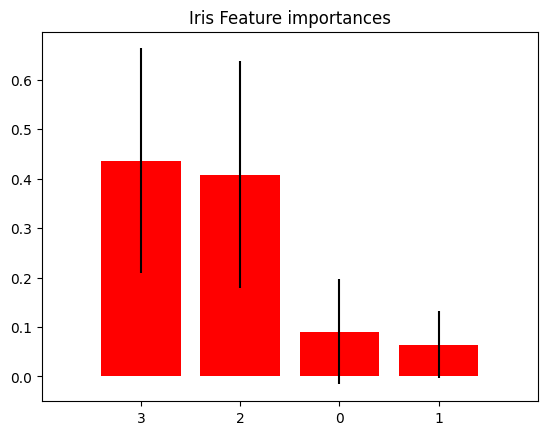

In [8]:
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
import numpy as np

forest = ExtraTreesClassifier(n_estimators=250, random_state=0)

forest.fit(iris_x, iris_y)
iris_importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(iris_importances)[::-1]

# Variables ordenadas por importancia
print("Iris Feature ranking:")
for f in range(iris_x.shape[1]):
	print(f"{f + 1}. feature {indices[f]} ({iris_importances[indices[f]]})")

plt.figure()
plt.title("Iris Feature importances")
plt.bar(range(iris_x.shape[1]), iris_importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(iris_x.shape[1]), indices)
plt.xlim([-1, iris_x.shape[1]])
plt.show()
